# Seed for Repoducibility

In [1]:
import hashlib
import string
import random
def get_reproducible_seeds(name="ProjectLong",nb_seeds=100):
    # Calculate SHA-256 hash
    sha256_hash = hashlib.sha256(name.encode()).hexdigest()
    # Define character sets
    digits = string.digits
    # Use the hash to seed the random number generator
    hash_as_int = int(sha256_hash, 16)
    random.seed(hash_as_int)
    # Generate a random list of seed of desired length
    reproducibility_seeds = [random.randint(0,10000) for _ in range(nb_seeds)]

    return reproducibility_seeds

In [2]:
reproducibility_seed=get_reproducible_seeds()[0]

# Small Dataset (15 days)

In [3]:
!wget http://sguangwang.com/dataset/telecom.zip
!unzip /content/telecom.zip


--2024-03-07 13:39:47--  http://sguangwang.com/dataset/telecom.zip
Resolving sguangwang.com (sguangwang.com)... 182.50.151.114
Connecting to sguangwang.com (sguangwang.com)|182.50.151.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53432897 (51M) [application/x-zip-compressed]
Saving to: ‘telecom.zip’

telecom.zip         100%[===================>]  50.96M  13.1MB/s    in 5.0s    

2024-03-07 13:39:52 (10.1 MB/s) - ‘telecom.zip’ saved [53432897/53432897]

Archive:  /content/telecom.zip
  inflating: dataset-telecom/data_6.1~6.30_.xlsx  


In [4]:
import pandas as pd
df=pd.read_excel("/content/dataset-telecom/data_6.1~6.30_.xlsx")
df.to_pickle("telecom_data.pkl")

## Prediction

### Prepocessing

In [5]:
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import math

# Load and sort the data
df = pd.read_pickle("telecom_data.pkl")
df = df.sort_values('start time')

# Define functions to extract latitude and longitude from location information
def get_x(value):
    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value

def get_y(value):
    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

# Apply extraction functions and normalize location information
df['x'] = df['location(latitude/lontitude)'].apply(get_x)
df['y'] = df['location(latitude/lontitude)'].apply(get_y)
df['x_normalised'] = (df['x'] - df['x'].mean()) / (df['x'].std())
df['y_normalised'] = (df['y'] - df['y'].mean()) / (df['y'].std())

# Encode time information
df['year_normalised'] = (df["start time"].dt.year - df["start time"].dt.year.min()) / (df["start time"].dt.year.max() - df["start time"].dt.year.min())
df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)
# ... include all time encoding code here

# Calculate communication duration
df['time_to_end'] = (df['end time'] - df['start time']).dt.total_seconds()

# Add new mobility features
#Calculate the total number of places visited by each user
df['pos'] = list(zip(df['x'], df['y']))
df['pos_count'] = df.groupby('user id')['pos'].transform('nunique')

#Identify the main activity period for each user
df['hour'] = df['start time'].dt.hour
df['period'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Create a mapping for position IDs
pos = df['pos'].unique()
vocab = dict(zip(pos, range(len(pos))))
vocab[(float('nan'), float('nan'))] = len(vocab)
def tokenize_pos(pos):
  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]
df['pos_id'] = df['pos'].apply(tokenize_pos)

# Create encoded time series
min_year = df["start time"].dt.year.min()
max_year = df["start time"].dt.year.max()
df['year_normalised'] = (df["start time"].dt.year - min_year) / (max_year - min_year)

df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)

df['time_to_end']=df['end time']-df['start time']
df['time_to_end']=df['time_to_end'].dt.total_seconds()

# Drop unused columns
df = df.drop(['month', 'date', 'end time', 'location(latitude/lontitude)', 'x', 'y', 'pos'], axis=1)

# Process data for each user
df_user_group = df.groupby('user id')
list_users = []

missing_data_threshold = 0.2
for user, df_user in df_user_group:
  if len(df_user) >= 2:
    non_missing_ratio_x = df_user['x_normalised'].notnull().mean()
    non_missing_ratio_y = df_user['y_normalised'].notnull().mean()
    if non_missing_ratio_x < missing_data_threshold or non_missing_ratio_y < missing_data_threshold:
            continue
    df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
    dict_user = df_user.to_dict('list')
    dict_user["time_to_next"][-1] = -1.
    dict_user["pos_id"] = torch.tensor(dict_user["pos_id"] + [len(vocab) + 1])

    dict_user["pos_id_target"] = dict_user["pos_id"][1:]
    dict_user["pos_id"] = dict_user["pos_id"][:-1]
    dict_user["input"] = torch.tensor([dict_user["x_normalised"], dict_user["y_normalised"], dict_user['month_sin'], dict_user['month_cos'], dict_user['day_sin'], dict_user['day_cos'], dict_user['hour_sin'], dict_user['hour_cos'], dict_user['minute_sin'], dict_user['minute_cos'], dict_user['second_sin'], dict_user['second_cos']]).T

    dict_user["time_target"] = torch.tensor([dict_user["time_to_end"], dict_user["time_to_next"]]).T

    # Replace NaN values with the values from the preceding row in the same column
    for i in range(1, dict_user["input"].size(0)):
        nan_positions = torch.isnan(dict_user["input"][i])
        dict_user["input"][i, nan_positions] = dict_user["input"][i - 1, nan_positions]

    # Remove unnecessary keys from the dictionary
    for key in ['x_normalised', 'y_normalised', 'year_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'time_to_end', 'time_to_next', 'start time', 'user id']:
        del dict_user[key]

    list_users.append(dict_user)

# Calculate mean and std for time targets
time_targets = torch.cat([user["time_target"] for user in list_users], dim=0)
time_targets_mean = time_targets.mean(dim=0)
time_targets_std = time_targets.std(dim=0)

# Normalize time targets for each user
for user in list_users:
  user["time_target"] = (user["time_target"] - time_targets_mean) / time_targets_std

# Save the processed data
torch.save(list_users, "list_users")
torch.save(vocab, 'vocab')


In [6]:
import torch

# Load processed user data and vocabulary mapping
list_users = torch.load("list_users")
vocab = torch.load('vocab')

# Display a part of the location encoding (vocab)
print("Partial location encodings (vocab):")
for key in list(vocab.keys())[:5]:  # Print the first 5 location encodings
    print(key, ":", vocab[key])

# Examine the data structure of a user
if list_users:  # If list_users is not empty
    sample_user = list_users[0]  # Take the data of the first user
    print("\nSample user data:")
    for key, value in sample_user.items():
        if key == 'input' or key == 'time_target':
            print(f"{key}: Shape = {value.shape}")  # If the value is a tensor, only print its shape
        else:
            print(f"{key}: {value[:5]}")  # Print the first 5 values
else:
    print("The list of users is empty, please check the data loading process.")



Partial location encodings (vocab):
(30.935314, 121.733322) : 0
(31.144812, 121.119606) : 1
(31.381763, 121.301878) : 2
(31.056648, 121.404326) : 3
(31.100034, 121.663489) : 4

Sample user data:
pos_count: [6, 6, 6, 6, 6]
hour: [2, 3, 10, 11, 20]
period: ['Night', 'Night', 'Morning', 'Morning', 'Evening']
pos_id: tensor([528, 874, 237, 528, 580])
pos_id_target: tensor([874, 237, 528, 580, 528])
input: Shape = torch.Size([14, 12])
time_target: Shape = torch.Size([14, 2])


In [7]:
# Print all location encodings (vocab)
print("All location encodings (vocab):")
for key, value in vocab.items():
    print(key, ":", value)


All location encodings (vocab):
(30.935314, 121.733322) : 0
(31.144812, 121.119606) : 1
(31.381763, 121.301878) : 2
(31.056648, 121.404326) : 3
(31.100034, 121.663489) : 4
(31.040378, 121.255563) : 5
(31.231508, 121.577691) : 6
(31.036429, 121.324198) : 7
(31.33775, 121.306733) : 8
(nan, nan) : 9
(31.298668, 121.541944) : 10
(31.187254, 121.536259) : 11
(30.889377, 121.176142) : 12
(29.526266, 119.910488) : 13
(31.327319, 121.462047) : 14
(31.113744, 121.341878) : 15
(31.250826, 121.578689) : 16
(31.338059, 121.289933) : 17
(31.349748, 121.506246) : 18
(31.246059, 121.362706) : 19
(31.414397, 121.481621) : 20
(31.078791, 121.422082) : 21
(31.129955, 121.336848) : 22
(31.210033, 121.405714) : 23
(31.355465, 121.412867) : 24
(31.254534, 121.34772) : 25
(31.202912, 121.712449) : 26
(31.319806, 121.526248) : 27
(31.282271, 121.524511) : 28
(31.215246, 121.604329) : 29
(31.025227, 121.44251) : 30
(30.808567, 121.29074) : 31
(34.638922, 119.467017) : 32
(31.094143, 121.488864) : 33
(31.24215

In [8]:
import torch

# Load the data
list_users = torch.load("list_users")
vocab = torch.load('vocab')

# Display all location encodings (vocab)
print("All location encodings (vocab):")
for key, value in vocab.items():
    print(key, ":", value)

# Display all user data
print("\nAll user data:")
for i, user_data in enumerate(list_users):
    print(f"\nUser {i + 1}:")
    for key, value in user_data.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Shape = {value.shape}")  # If the value is a tensor, print its shape
        else:
            print(f"{key}: {value}")  # Otherwise, print the value directly


流式输出内容被截断，只能显示最后 5000 行内容。
input: Shape = torch.Size([2, 12])
time_target: Shape = torch.Size([2, 2])

User 616:
pos_count: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



流式输出内容被截断，只能显示最后 5000 行内容。
User 2698:
pos_count: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




hour: [23, 7, 10, 10, 10, 23, 2, 5, 7, 8, 11, 14, 17, 5, 7, 8, 11, 14, 17, 19, 6, 7, 9, 12, 15, 18, 18, 18, 18, 18, 19, 19, 23, 5, 7, 8, 11, 14, 17, 19, 20, 7, 10, 14, 17, 19, 20, 22, 23, 23, 5, 5, 7, 8, 11, 12, 12, 14, 17, 20, 6, 7, 9, 10, 12, 13, 14, 15, 15, 20, 21, 22, 23, 23, 23, 6, 7, 9, 12, 15, 18, 6, 7, 9, 12, 15, 18, 20, 23, 23, 2, 5, 7, 8, 11, 14, 17, 19, 19, 20, 22, 23, 23, 6, 7, 9, 12, 15, 18, 5, 7, 10, 13, 18, 20, 21, 10, 13, 15, 18, 19, 7, 7, 10, 14, 14, 16, 17, 20, 21, 21, 22]
period: ['Evening', 'Morning', 'Morning', 'Morning', 'Morning', 'Evening', 'Night', 'Night', 'Morning', 'Morning', 'Morning', 'Afternoon', 'Afternoon', 'Night', 'Morning', 'Morning', 'Morning', 'Afternoon', 'Afternoon', 'Evening', 'Night', 'Morning', 'Morning', 'Morning', 'Afternoon', 'Afternoon', 'Afternoon', 'Afternoon', 'Afternoon', 'Afternoon', 'Evening', 'Evening', 'Evening', 'Night', 'Morning', 'Morning', 'Morning', 'Afternoon', 'Afternoon', 'Evening', 'Evening', 'Morning', 'Morning', 'Aftern

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




User 5482:
pos_count: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
hour: [5, 8, 10, 12, 14, 19, 20, 22, 23, 5, 11, 11, 13, 14, 14, 14, 15, 15, 16, 17, 17, 17, 18, 19, 19, 21, 5, 10, 11, 5, 5, 6, 7, 7, 13, 15, 17, 17, 17, 18, 19, 19, 21, 9, 9, 12, 14, 15, 16, 17, 18, 18, 20, 5, 5, 6, 7, 8, 10, 12, 13, 16, 16, 18, 19, 20, 21, 21, 23, 5, 7, 9, 9, 9, 10, 12, 14, 21, 22, 9, 11, 13, 13, 13, 16, 20, 21, 22, 9, 10, 13, 16, 20, 20, 

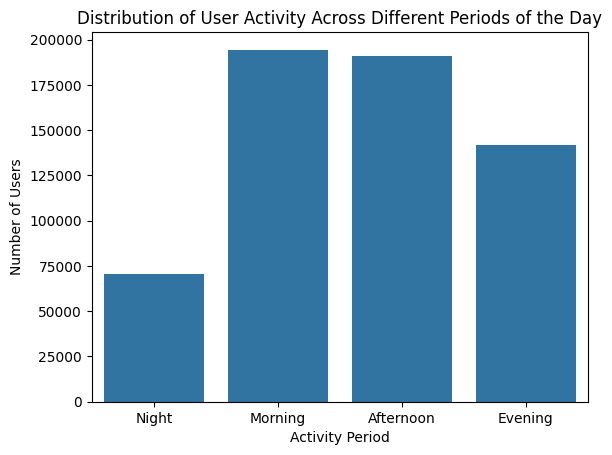

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


period_counts = df['period'].value_counts()


sns.barplot(x=period_counts.index, y=period_counts.values)
plt.xlabel('Activity Period')
plt.ylabel('Number of Users')
plt.title('Distribution of User Activity Across Different Periods of the Day')
plt.show()


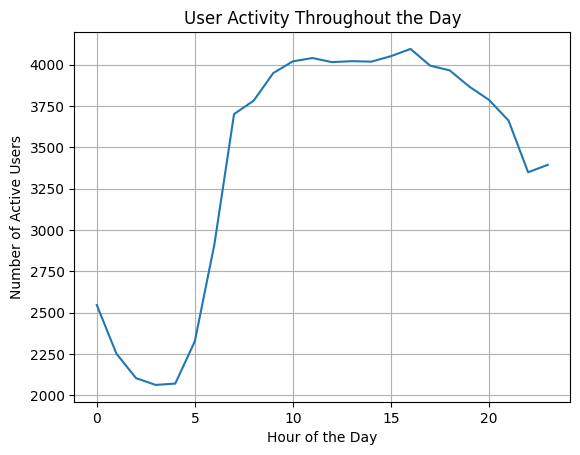

In [12]:

hourly_activity = df.groupby('hour')['user id'].nunique()

plt.plot(hourly_activity.index, hourly_activity.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Active Users')
plt.title('User Activity Throughout the Day')
plt.grid(True)
plt.show()


### Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDataset(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id_target'], user_dict['time_target']

dataset=VariableLengthDataset(list_users)

In [ ]:
dataset.__getitem__(0)[0].shape

torch.Size([14, 12])

In [ ]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))

    ## compute mask
    mask_time_targets = (time_targets != -1)
    return inputs, time_targets, pos_ids, lengths, mask_time_targets
dataloader=DataLoader(dataset,batch_size=64,collate_fn=collate_fn_padd,shuffle=True)

In [ ]:
next(iter(dataloader))

(tensor([[[ 1.8893e-01,  6.4451e-02,  1.2246e-16,  ..., -8.0902e-01,
            4.0674e-01,  9.1355e-01],
          [ 1.8893e-01,  6.4451e-02,  1.2246e-16,  ..., -8.6603e-01,
           -8.0902e-01,  5.8779e-01],
          [ 1.8893e-01,  6.4451e-02,  1.2246e-16,  ..., -9.1355e-01,
           -1.0000e+00, -1.8370e-16],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 1.9504e-01,  9.0874e-02,  1.2246e-16,  ..., -5.8779e-01,
           -7.4314e-01,  6.6913e-01],
          [ 1.9504e-01,  9.0874e-02,  1.2246e-16,  ..., -6.6913e-01,
            3.0902e-01,  9.5106e-01],
          [ 1.9504e-01,  9.0874e-02,  1.2246e-16,  ..., -4.0674e-01,
           -2.0791e-01,  9.7815e-01],
          ...,
    

### Classic Training


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import StepLR

epochs=17
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)
scheduler = StepLR(optimizer_encoder, step_size=5, gamma=0.1)

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
      loss_regression = (loss_regression * mask_time_targets.float()).mean()
      loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)
  scheduler.step()



epoch: 0 loss: 7.777284413241269
epoch: 1 loss: 7.721086930692866
epoch: 2 loss: 7.713943122478014


KeyboardInterrupt: 

In [ ]:
pip install optuna

In [ ]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import LSTM
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader



def objective(trial):

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    num_layers = trial.suggest_int('num_layers', 1, 3)


    encoder = LSTM(input_size=12, hidden_size=hidden_size, batch_first=True, num_layers=num_layers).cuda()
    optimizer_encoder = optim.Adam(encoder.parameters(), lr=lr)
    scheduler = StepLR(optimizer_encoder, step_size=5, gamma=0.1)

    criterion_classification = nn.CrossEntropyLoss(ignore_index=len(vocab))
    criterion_regression = nn.MSELoss(reduction='none')

    epochs = 17
    train_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
            optimizer_encoder.zero_grad()
            inputs = inputs.float().cuda()
            time_targets = time_targets.cuda()
            pos_ids = pos_ids.cuda()
            mask_time_targets = mask_time_targets.cuda()
            packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
            with autocast(device_type="cuda"):
              packed_output,(ht, ct)=encoder(packed_batch)
              output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
              loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
              loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
              loss_regression = (loss_regression * mask_time_targets.float()).mean()
              loss=loss_classification+1e-7*loss_regression
            loss.backward()
            optimizer_encoder.step()
            epoch_losses.append(loss.item())

        scheduler.step()
        epoch_loss = np.mean(epoch_losses)
        train_losses.append(epoch_loss)


    return np.mean(train_losses)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


NameError: name 'optuna' is not defined

### Sequencing Classification and regression

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
lr=0.001
epochs=epochs_complete_problem+ epochs_classifcation_only
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters(),lr=lr)
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      if epoch>=epochs_classifcation_only:
        loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
      else:
        loss=loss_classification
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

epoch: 0 loss: 7.767892039224003
epoch: 1 loss: 7.714855842376023
epoch: 2 loss: 7.708208148399096
epoch: 3 loss: 7.69823560286104
epoch: 4 loss: 7.666130232007316
epoch: 5 loss: 7.656750737951043
epoch: 6 loss: 7.667173278465699
epoch: 7 loss: 7.669696406032262
epoch: 8 loss: 7.671635295567888
epoch: 9 loss: 7.677104724926895
epoch: 10 loss: 7.681260564354028
epoch: 11 loss: 7.680728076549059
epoch: 12 loss: 7.685436527380783
epoch: 13 loss: 7.706086174825604
epoch: 14 loss: 7.716381137290697
epoch: 15 loss: 7.72348727001233
epoch: 16 loss: 7.721491910098644
epoch: 17 loss: 7.718485901864727
epoch: 18 loss: 7.727401422650627
epoch: 19 loss: 7.7441011493125655


### Modified architecture

In [ ]:
class LSTM_Classification_regression(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,num_layers,batch_first=True):
    super().__init__(self)
    self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
  def forward(self,x,reg=True):
    x,_=self.lstm(x)
    x=F.relu(x)
    if reg:
      return self.classifier(x),self.linear_reg(x)
    else:
      return self.classifier(x)



NameError: name 'nn' is not defined

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
input_size=12
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size
epochs=epochs_complete_problem+ epochs_classifcation_only
model=LSTM_Classification_regression(input_size, hidden_size,output_regression_size,output_classfication_size,num_layers).cuda()

optimizer_encoder = optim.Adam(encoder.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for x, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    batch_size=x.shape[0]
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,reg=False)
        x=pad_packed_sequence(torch.nn.utils.rnn.PackedSequence(out, batch_size), batch_first=True)
        loss=criterion_classification(x.transpose(1,2),pos_ids)
      else:
        x,y=model(x,reg=True)
        loss_classification=criterion_classification(x.transpose(1,2),pos_ids)
        loss_regression=criterion_regression(F.relu(y),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

### Embeddings


#### New Dataset with  current pos_id

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id'],user_dict['pos_id_target'], user_dict['time_target']
def create_dataset(list_users,split=[0.8,0.1,0.1]):
  dataset=VariableLengthDatasetWithPosID(list_users)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
  return dataset_list


In [ ]:
len(dataset.times_series)

NameError: name 'dataset' is not defined

In [ ]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,pos_id_targets,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))
    pos_id_targets = torch.nn.utils.rnn.pad_sequence(pos_id_targets,batch_first=True,padding_value=len(vocab))


    return inputs, pos_ids, time_targets, pos_id_targets, lengths



#### Modified Model with embeddings

In [ ]:
dataset_list=create_dataset(list_users)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=32,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)

In [ ]:
import torch.nn as nn
import torch
from torch.nn import Embedding, LSTM
import torch.nn.functional as F

class LSTM_Classification_regression_Embeddings(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers,batch_first=True):
    super().__init__()
    self.lstm = LSTM(input_size=input_size+embedding_dim, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
    self.embeddings=nn.Embedding(num_embeddings=output_classfication_size,embedding_dim=embedding_dim)

  def forward(self,x,pos_id,lengths,reg=True):
    #BEFORE: x.shape=(batch_size, max_sequence_length,input_size); pos_id.shape=(batch_size,max_sequence_length)
    x=torch.cat([x,self.embeddings(pos_id)],dim=2)
    #AFTER: x.shape=(batch_size, max_sequence_length, input_size+embedding_dim)
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    # x.data.shape=([length_i for i in range(batch_size)].sum(),input_size+embedding_dim)
    x,_=self.lstm(x)
    data=F.relu(x.data)
    if reg:
      x = torch.nn.utils.rnn.PackedSequence(self.classifier(data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      y = torch.nn.utils.rnn.PackedSequence(torch.exp(self.linear_reg(data)), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      return x,y
    else:
      return  torch.nn.utils.rnn.PackedSequence(self.classifier(data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)

In [ ]:
def evaluate(model,dataloader,criterion_classification,criterion_regression):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    for x, pos_ids, time_targets, target_pos_ids, lengths in dataloader:
      batch_size=x.shape[0]
      x=x.float().cuda()
      pos_ids=pos_ids.cuda()
      time_targets = time_targets.cuda()
      target_pos_ids = target_pos_ids.cuda()
      with autocast(device_type="cuda"):
        x,y=model(x,pos_ids,lengths,reg=True)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        time_targets=torch.nn.utils.rnn.pack_padded_sequence(time_targets, lengths=lengths,batch_first=True, enforce_sorted=False)
        ## compute mask
        mask_time_targets = (time_targets.data != -1)
        loss_classification=criterion_classification(x.data,target_pos_ids.data)
        acc+=(x.data.argmax(dim=1)==target_pos_ids.data).sum()
        nb_points+=x.data.shape[0]
        loss_regression=criterion_regression(y.data,time_targets.data)
        loss_regression = (loss_regression * mask_time_targets.data.float()).mean()
        loss=loss_classification+loss_regression
    return acc.item()/(nb_points),loss_classification.item()/len(dataloader),loss_regression.item()/len(dataloader)


In [ ]:
print(len(valid_dataloader)*10)

580


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
## parameters
#training params
epochs_classifcation_only=10
epochs_complete_problem =20
epochs=epochs_complete_problem+ epochs_classifcation_only
#Model params
input_size=12
embedding_dim=400
num_layers=4
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size

model=LSTM_Classification_regression_Embeddings(input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers).cuda()
optimizer_encoder = optim.Adam(model.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
valid_accs=[]
valid_losses_classification=[]
valid_losses_regression=[]
for epoch in range(epochs):
  model.train()
  epoch_losses=[]
  for x, pos_ids, time_targets, target_pos_ids, lengths in train_dataloader:
    optimizer_encoder.zero_grad()
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    time_targets = time_targets.cuda()
    #print(target_pos_ids)
    target_pos_ids = target_pos_ids.cuda()
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,pos_ids,lengths,reg=False)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        loss=criterion_classification(x.data,target_pos_ids.data)
      else:
        x,y=model(x,pos_ids,lengths,reg=True)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        time_targets=torch.nn.utils.rnn.pack_padded_sequence(time_targets, lengths=lengths,batch_first=True, enforce_sorted=False)
        mask_time_targets = (time_targets.data != -1)
        loss_classification=criterion_classification(x.data,target_pos_ids.data)
        loss_regression=criterion_regression(y.data,time_targets.data)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression

    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  train_losses.append(loss_epoch)
  valid_acc,valid_loss_classification,valid_loss_regression=evaluate(model,valid_dataloader,criterion_classification,criterion_regression)
  valid_accs.append(valid_acc)
  valid_losses_classification.append(valid_loss_classification)
  valid_losses_regression.append(valid_loss_regression)
  print("epoch: "+str(epoch)+" train loss: "+str(loss_epoch)+" valid_acc: "+str(valid_acc)," valid_loss_classification: "+str(valid_loss_classification)+" valid_loss_regression: "+str(valid_loss_regression))

epoch: 0 train loss: 6.551205036375258 valid_acc: 0.32183010877688284  valid_loss_classification: 1.5915258725484211 valid_loss_regression: 0.6874008178710938
epoch: 1 train loss: 3.7312705331378515 valid_acc: 0.46981649090758115  valid_loss_classification: 1.0163533687591553 valid_loss_regression: 0.6963268915812174
epoch: 2 train loss: 2.6541660997602676 valid_acc: 0.533654405048576  valid_loss_classification: 0.7919421195983887 valid_loss_regression: 0.6965961456298828
epoch: 3 train loss: 2.204934208922916 valid_acc: 0.5659387195881425  valid_loss_classification: 0.7073539892832438 valid_loss_regression: 0.7110209465026855
epoch: 4 train loss: 1.986035825146569 valid_acc: 0.5732790832848957  valid_loss_classification: 0.6577861309051514 valid_loss_regression: 0.6914376417795817
epoch: 5 train loss: 1.838186095820533 valid_acc: 0.5850369509258491  valid_loss_classification: 0.6108259359995524 valid_loss_regression: 0.6918560663859049
epoch: 6 train loss: 1.7388380103641086 valid_acc

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

### Transfomers

Split Long-sequences

In [ ]:
def split_long_sequences(list_users,max_sequence_length):
  new_list_users=[]
  for i in range(len(list_users)):
    #print(i)
    seq_length=list_users[i]["input"].shape[0]
    if seq_length>=max_sequence_length:
      div=2
      while max_sequence_length/div >= max_sequence_length:
        div+=1
      new_seq_length=seq_length//div
      list_splitted_seq=div*[{}]
      for key in list_users[i]:
        for j in range(div):
          if j!=div-1:
            list_splitted_seq[j][key]=list_users[i][key][div*j:div*(j+1)]
          else:
            list_splitted_seq[j][key]=list_users[i][key][div*j:]
      new_list_users+list_splitted_seq
    else:
      new_list_users.append(list_users[i])
  return new_list_users

splitted_list_user=split_long_sequences(list_users,500)

In [ ]:
dataset_list=create_dataset(splitted_list_user)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=32,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=False)

In [ ]:
import torch.nn as nn
from torch import nn, Tensor
import math
def get_mask(bath_size,sequence_length,lengths):
  mask=torch.zeros(bath_size,sequence_length).cuda()
  for i, length in enumerate(lengths):
    mask[i,length:]=1
  return mask.bool()
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = (x.transpose(0,1) + self.pe[:x.transpose(0,1).size(0)]).transpose(0,1)
        return self.dropout(x)

class Transformer_Classification_regression(nn.Module):

  def __init__(self,embedding_dim,d_model,output_classfication_size,output_regression_size,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
    super().__init__()

    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.linear_reg=nn.Linear(d_model,output_regression_size)
    self.classifier=nn.Linear(d_model,output_classfication_size)
    self.embedding=nn.Embedding(num_embeddings=output_classfication_size,embedding_dim=embedding_dim)
    self.init_weights()
    self.d_model=d_model
  def init_weights(self) -> None:
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.classifier.bias.data.zero_()
    self.classifier.weight.data.uniform_(-initrange, initrange)

  def forward(self,x,pos_id,lengths,reg=True):
    torch.autograd.set_detect_anomaly(True)
    x=torch.cat([x,self.embedding(pos_id)],dim=2)* math.sqrt(self.d_model)
    #print(x[0,:,0])

    self.pos_encoder(x)
    with torch.no_grad():
      mask_x = get_mask(x.shape[0],x.shape[1],lengths)
      causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device= torch.device('cuda'))
    #print(mask_x[0])
    #print("before transformers: ", torch.isnan(x).sum())
    x=self.transformer_encoder( x,
                        mask = causal_mask,
                        src_key_padding_mask = mask_x,
                        is_causal = True)
    #print("after: ",torch.isnan(x).sum())
    #print(x[0,:,0])
    x=F.relu(x)
    #print(x.shape,mask_x.shape)
    #del mask_x
    del causal_mask

    if reg:
      return self.classifier(x),torch.exp(self.linear_reg(x))
    else:
      return  self.classifier(x)

In [ ]:
def evaluate(model,dataloader,criterion_classification,criterion_regression):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    for x, pos_ids, time_targets, target_pos_ids, lengths in dataloader:
      x=x.float().cuda()
      pos_ids=pos_ids.cuda()
      time_targets = time_targets.cuda()
      target_pos_ids = target_pos_ids.cuda()
      with autocast(device_type="cuda"):
        x,y=model(x,pos_ids,lengths,reg=True)
        mask_time_targets = (time_targets != -1)
        loss_classification=criterion_classification(x.transpose(1,2),target_pos_ids)
        acc+=((target_pos_ids!=len(vocab))*(x.argmax(dim=2)==target_pos_ids)).sum()
        nb_points+=lengths.sum()
        loss_regression=criterion_regression(y,time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression

    return acc.item()/(nb_points),loss_classification.item()/len(dataloader),loss_regression.item()/len(dataloader)

In [ ]:
len(vocab)+2

2773

In [ ]:
torch.cuda.memory_allocated()

4340235776

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
import numpy as np

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.autograd.set_detect_anomaly(True)
## parameters
#training params

epochs_classifcation_only=20
epochs_complete_problem =10
epochs=epochs_complete_problem+ epochs_classifcation_only
#Model params
nhead=10
num_layers=3
d_model=2780

input_size=12
output_regression_size=2
output_classfication_size=len(vocab)+2
embedding_dim=d_model-input_size

model=Transformer_Classification_regression(embedding_dim,
                                            d_model,
                                            output_classfication_size,
                                            output_regression_size,
                                            num_layers,
                                            nhead
                                            ).cuda()
lr=5e-5
optimizer_encoder = optim.Adam(model.parameters(),lr=lr)

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index = len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction = 'none')

train_losses=[]
valid_accs=[]
valid_losses_classification=[]
valid_losses_regression=[]
for epoch in range(epochs):
  model.train()
  epoch_losses=[]
  for x, pos_ids, time_targets, target_pos_ids, lengths in train_dataloader:

    optimizer_encoder.zero_grad()
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    target_pos_ids = target_pos_ids.cuda()

    with autocast(device_type="cuda"):

      if epoch<epochs_classifcation_only:
        #print(torch.isnan(x).sum())
        x=model(x,pos_ids,lengths,reg=False)
        #print(torch.isnan(x).sum())
        loss=criterion_classification(x.transpose(1,2),target_pos_ids)
        #print(loss)
        #break
      else:
        time_targets = time_targets.cuda()
        x,y=model(x,pos_ids,lengths,reg=True)
        mask_time_targets = (time_targets != -1)
        loss_classification=criterion_classification(x.transpose(1,2),target_pos_ids)
        loss_regression=criterion_regression(y,time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())

    del loss
    del x
    del pos_ids
    del target_pos_ids
  #break
  loss_epoch=np.mean(epoch_losses)
  train_losses.append(loss_epoch)

  valid_acc,valid_loss_classification,valid_loss_regression=evaluate(model,valid_dataloader,criterion_classification,criterion_regression)
  valid_accs.append(valid_acc)
  valid_losses_classification.append(valid_loss_classification)
  valid_losses_regression.append(valid_loss_regression)
  print("epoch: "+str(epoch)+" train loss: "+str(loss_epoch)+" valid_acc: "+str(valid_acc)," valid_loss_classification: "+str(valid_loss_classification)+" valid_loss_regression: "+str(valid_loss_regression))

epoch: 0 train loss: 6.748741766789577 valid_acc: tensor(0.3581)  valid_loss_classification: 1.0690626144409179 valid_loss_regression: 0.11667957305908203
epoch: 1 train loss: 3.332552359654353 valid_acc: tensor(0.4693)  valid_loss_classification: 0.8394713401794434 valid_loss_regression: 0.10623537302017212
epoch: 2 train loss: 2.69407950247918 valid_acc: tensor(0.4951)  valid_loss_classification: 0.755768871307373 valid_loss_regression: 0.10635854005813598
epoch: 3 train loss: 2.440443414908189 valid_acc: tensor(0.5067)  valid_loss_classification: 0.7017522811889648 valid_loss_regression: 0.10711054801940918
epoch: 4 train loss: 2.316219290653309 valid_acc: tensor(0.5056)  valid_loss_classification: 0.672732925415039 valid_loss_regression: 0.1111256241798401
epoch: 5 train loss: 2.152582621240949 valid_acc: tensor(0.5135)  valid_loss_classification: 0.6609856128692627 valid_loss_regression: 0.10628269910812378
epoch: 6 train loss: 2.038777289690671 valid_acc: tensor(0.5174)  valid_lo

In [ ]:
import gc
del model
del optimizer_encoder
del x
del optimizer_encoder


833

# XGBoost


In [ ]:
df['start time'].dt.year.unique()

array([2014])

Preprocessing

In [ ]:
import torch
import numpy as np
import pandas as pd
from warnings import simplefilter
#simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
df= pd.read_pickle("telecom_data.pkl")
df=df.sort_values('start time')
def get_x(value):
    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value
def get_y(value):
    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

df['x'] = df['location(latitude/lontitude)'].apply(get_x)
df['y'] = df['location(latitude/lontitude)'].apply(get_y)
df['pos']= list(zip(df['x'],df['y']))
df['pos_category']=df['pos'].astype('category')
df['month']=df["start time"].dt.month
df['day']=df["start time"].dt.day
df['hour']=df["start time"].dt.hour
df['minute']=df["start time"].dt.minute
df['second']=df["start time"].dt.second
df=df.drop([ 'date', 'end time', 'location(latitude/lontitude)','pos'], axis=1)
df['pos_category']=df['pos_category'].cat.add_categories(['<stop>'])
df_user_group = df.groupby('user id')
columns_to_shift = ['pos_category', 'month', 'day', 'minute', 'second']
nb_of_lags=500
concatenated_dfs = []
usier_i=0
print(len(df_user_group))
for user, df_user in df_user_group:

  usier_i+=1
  print(usier_i)
  if len(df_user)>=2:

    concatenated_dfs.append(pd.concat([df_user,pd.DataFrame({f'{col}_{i}': df_user[col].shift(periods=i) for col in columns_to_shift for i in range(1,nb_of_lags)})],axis=1))
concatenated_df = pd.concat(concatenated_dfs)




6608
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276

In [ ]:
result

,0,1,2,3,4,5,6,7,8,9,10,11
0,6,2014-06-01 02:37:07,0010eb6cd724b3d5fda54cbba05c23f6,31.179835,121.429502,"(31.179835, 121.429502)",1,2,37,7,NaN,NaT
1,6,2014-06-01 03:01:02,0010eb6cd724b3d5fda54cbba05c23f6,31.172757,121.425965,"(31.172757, 121.425965)",1,3,1,2,"(31.179835, 121.429502)",2014-06-01 02:37:07
2,6,2014-06-01 10:21:56,0010eb6cd724b3d5fda54cbba05c23f6,31.176998,121.423586,"(31.176998, 121.423586)",1,10,21,56,"(31.172757, 121.425965)",2014-06-01 03:01:02
3,6,2014-06-01 11:18:13,0010eb6cd724b3d5fda54cbba05c23f6,31.179835,121.429502,"(31.179835, 121.429502)",1,11,18,13,"(31.176998, 121.423586)",2014-06-01 10:21:56
4,6,2014-06-02 20:23:01,0010eb6cd724b3d5fda54cbba05c23f6,31.176050,121.431225,"(31.17605, 121.431225)",2,20,23,1,"(31.179835, 121.429502)",2014-06-01 11:18:13
...,...,...,...,...,...,...,...,...,...,...,...,...
610764,6,2014-06-15 14:01:38,fffd23d0da480c4032ed19c2fe7cbfae,31.195131,121.418788,"(31.195131, 121.418788)",15,14,1,38,"(nan, nan)",2014-06-15 11:50:25
610765,6,2014-06-15 14:26:42,fffd23d0da480c4032ed19c2fe7cbfae,31.195131,121.418788,"(31.195131, 121.418788)",15,14,26,42,"(31.195131, 121.418788)",2014-06-15 14:01:38
610766,6,2014-06-15 15:54:18,fffd23d0da480c4032ed19c2fe7cbfae,31.195907,121.410659,"(31.195907, 121.410659)",15,15,54,18,"(31.195131, 121.418788)",2014-06-15 14:26:42
610767,6,2014-06-15 15:57:00,fffd23d0da480c4032ed19c2fe7cbfae,31.195907,121.410659,"(31.195907, 121.410659)",15,15,57,0,"(31.195907, 121.410659)",2014-06-15 15:54:18


In [ ]:
for user, df_user in df_user_group:

  usier_i+=1
  print(usier_i)
  if len(df_user)>=2:

    concatenated_dfs.append(pd.concat([df_user,pd.DataFrame({f'{col}_{i}': df_user[col].shift(periods=i) for col in columns_to_shift for i in range(1,nb_of_lags)})],axis=1,ignore_index=True))
concatenated_df = pd.concat(concatenated_dfs, ignore_index=True)
print(concatenated_df)

In [ ]:
df = pd.DataFrame(
     [[10, 13, 17], [20, 23, 27], [15, 18, 22], [30, 33, 37], [45, 48, 52]],
     columns=["Col1", "Col2", "Col3"],
     index=pd.date_range("2020-01-01", "2020-01-05"),
)
df["Col1"].shift([1,2,3])

TypeError: '>' not supported between instances of 'list' and 'int'

In [ ]:
import pandas as pd

# Example DataFrame
data = {'A': [1, 2, 3, 4, 5],
        'B': [6, 7, 8, 9, 10],
        'C': [11, 12, 13, 14, 15]}

df = pd.DataFrame(data)
print(df)
# Apply cumulative sum along the columns
df_cumsum = df.cumsum()

# Shift the DataFrame to move the cumulative sum one row down
df_shifted = df_cumsum.shift(fill_value=0)

# Add the shifted DataFrame to the original DataFrame
df_result = df + df_shifted

print(df_result)


   A   B   C
0  1   6  11
1  2   7  12
2  3   8  13
3  4   9  14
4  5  10  15
    A   B   C
0   1   6  11
1   3  13  23
2   6  21  36
3  10  30  50
4  15  40  65


In [ ]:
import pandas as pd

# Example DataFrame
data = {'A': [1, 2, 3, 4, 5],
        'B': [6, 7, 8, 9, 10],
        'C': [11, 12, 13, 14, 15]}

df = pd.DataFrame(data)

# Define a function to concatenate all preceding elements in a column
def concat_preceding(series):
    result = []
    cumulative = ""
    for value in series:
        cumulative += str(value)
        result.append(cumulative)
    return result

# Apply the function to each column
df_concat = df.apply(concat_preceding)

print(df_concat)

       A       B           C
0      1       6          11
1     12      67        1112
2    123     678      111213
3   1234    6789    11121314
4  12345  678910  1112131415


In [ ]:
dic.keys()

dict_keys([(22.522803, 114.218796), (24.284812, 102.999068), (25.222206, 117.086322), (26.139329, 103.078562), (26.215115, 109.744661), (28.738742, 120.640606), (28.812629, 115.952954), (29.151779, 120.985563), (29.263844, 115.023159), (29.526266, 119.910488), (30.442177, 120.618727), (30.679943, 104.067923), (30.705762, 121.33512), (30.715526, 121.351073), (30.716044, 121.291037), (30.716187, 121.349498), (30.718108, 121.283169), (30.718302, 121.314644), (30.719537, 121.355948), (30.719644, 121.345988), (30.721392, 121.345766), (30.723654, 121.330778), (30.72456, 121.344043), (30.730296, 121.342643), (30.730789, 121.343497), (30.731903, 121.334173), (30.733903, 121.341904), (30.73407, 121.350673), (30.734301, 121.25722), (30.735262, 121.351726), (30.735272, 121.380359), (30.735389, 121.358248), (30.736093, 121.355957), (30.736314, 121.354852), (30.738649, 121.382934), (30.739639, 121.373695), (30.739797, 121.32739), (30.741272, 121.3348), (30.74139, 121.380141), (30.741693, 121.367052

In [ ]:



df_user_group = df.groupby('user id')
list_users=[]
for user, df_user in df_user_group:
  if len(df_user)>=2:
    df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
    dict_user=df_user.to_dict('list')
    dict_user["time_to_next"][-1]=-1.
    dict_user["pos_id"]=torch.tensor(dict_user["pos_id"]+[len(vocab)+1])

    dict_user["pos_id_target"]=dict_user["pos_id"][1:]
    dict_user["pos_id"]=dict_user["pos_id"][:-1]
    dict_user["input"]=torch.tensor([dict_user["x_normalised"],dict_user["y_normalised"],dict_user['month_sin'], dict_user['month_cos'], dict_user['day_sin'], dict_user['day_cos'], dict_user['hour_sin'], dict_user['hour_cos'], dict_user['minute_sin'], dict_user['minute_cos'], dict_user['second_sin'], dict_user['second_cos']]).T
    #print(dict_user["input"].shape,dict_user["input"].T.shape)
    dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
    j=1
    i=0
    while i < dict_user["input"].size(0) and torch.isnan(dict_user["input"][i,j]):
      i+=1
    if i < dict_user["input"].size(0):
      dict_user["input"][:i,0]=dict_user["input"][i,0]
      dict_user["input"][:i,1]=dict_user["input"][i,1]
      nan_positions = torch.isnan(dict_user["input"])
      # Step 2: Replace NaN values with the values from the preceding row of the same column
      for i in range(i+1, dict_user["input"].size(0)):
        dict_user["input"][i, nan_positions[i]] = dict_user["input"][i - 1, nan_positions[i]]

      for e in ['x_normalised', 'y_normalised','year_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'time_to_end', 'time_to_next','start time', 'user id']:
        dict_user.pop(e)
      list_users.append(dict_user)
time_targets=torch.cat([dict_user["time_target"] for dict_user in list_users],dim=0)
time_targets_mean=time_targets.mean(dim=0)
time_targets_std=time_targets.std(dim=0)

for i in range(len(list_users)):
  list_users[i]["time_target"]=(list_users[i]["time_target"]-time_targets_mean)/time_targets_std
torch.save(list_users,"list_users")
torch.save(vocab,'vocab')

KeyError: 'pos_id'

## Data Analysis

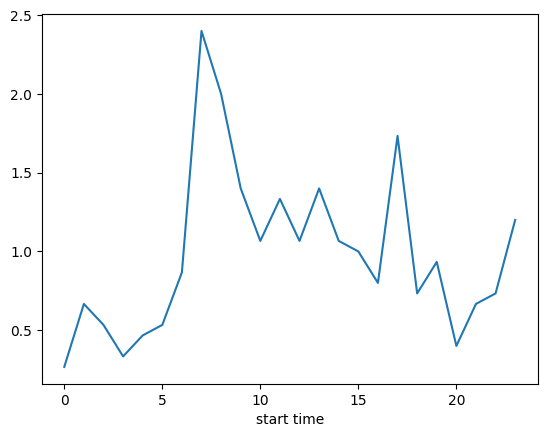

In [ ]:
grouped_id=df_xlsx.groupby('location(latitude/lontitude)')
i=0
for id,df_id in grouped_id:
  #print(id)
  (df_id.groupby([df_id["start time"].dt.hour])["start time"].count()/15).plot()
  i+=1
  break
  if i>=1000:
    break


In [ ]:
dataset_dic=np.load("./TelecomDataset/dataset_dic.npy",allow_pickle=True)

In [ ]:
dataset_dic=delete_overlaps_dataset(dataset_dic)

In [ ]:
dataset_dic, list_id = convervt_id_to_idx(dataset_dic)

In [ ]:
dic_station, list_station=get_dic_station(dataset_dic)

In [ ]:
dataset_dic=add_class(dataset_dic,dic_station)

In [ ]:
idx=2
start_times=dataset_dic[idx]["start time"]
end_times=dataset_dic[idx]["end time"]
nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15)
nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15)

In [ ]:
print(nb_time_step_connections,nb_time_step_btwn_connections)

In [ ]:
mean=get_mean_connect_time(dataset_dic)

In [ ]:
print((dataset_dic[2]['end time'][0]-dataset_dic[2]['start time'][0]).astype('timedelta64[m]'))


22 minutes


In [ ]:
import numpy as np
np.arange(100).reshape(10,10).reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
def blank_name(dataset_dic,idx)
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15).int()
    nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15).int()
    repmat(


In [ ]:

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, dataset_dic, input_sequence_len, output_size=1, nan_started=0, nan_stopped=0, missing_indices=np.array([])):
        self.data = dataset_dic
        self.input_sequence_len = input_sequence_len
        self.output_size = output_size
        self.nan_started = nan_started
        self.missing_data_len = nan_stopped - nan_started
        self.missing_indices = missing_indices

    def __len__(self):
        return len(self.data) - 2*self.input_sequence_len - 2*self.output_size - self.missing_data_len

    def __getitem__(self, idx):
        self.data =
        dic_idx= self.data[idx]
        =dic_idx['start time']
        stop_sequence_idx = start_idx + self.input_sequence_len
        stop_target_idx = stop_sequence_idx + self.output_size
        # If considered sequence intersects with the missing value list [11122, .... ,11133]
        # jump to 11134 index
        if np.intersect1d(np.arange(start_idx, stop_target_idx), self.missing_indices).size > 0:
          start_idx = self.missing_indices[-1] + 1

        # Avoid the missing data range
        if stop_target_idx >= self.nan_started :
            start_idx += self.missing_data_len + self.input_sequence_len + self.output_size
            stop_sequence_idx = start_idx + self.input_sequence_len
            stop_target_idx = stop_sequence_idx + self.output_size
        # Extracting a sequence of data
        # YOUR CODE HERE
        assert sequence.shape[0] == self.input_sequence_len
        assert target.shape[0] == self.output_size
        return {'sequence': torch.Tensor(sequence), 'target': torch.Tensor(target)}

NameError: ignored

In [ ]:
nb=0
nb2=0
nb3=0
nb4=0
for id in dataset_dic:
  dic_id=dataset_dic[id]
  startarray=dic_id['start time']
  endarray=dic_id['end time']
  lattitude_array=dic_id['latitude']
  for i in range(len(startarray)-1):
    if startarray[i]>endarray[i]:
      nb4+=0
      print("element :"+str(i)+" of id: "+id)
    if startarray[i+1]<endarray[i]:
      nb+=1
    else:
      nb2+=1
    if startarray[i+1]<endarray[i] and lattitude_array[i]!=lattitude_array[i+1]:
      nb3+=1
    if startarray[i+1]<startarray[i]:
      nb+=0
      print("not sorted")
print(nb,nb2,nb3,nb4)


0 6943182 0 0


KeyError: ignored

In [ ]:
nb4

0

In [ ]:
import numpy as np
df=df.loc[np.isnan(df['latitude'])==False]
print(df)

df['month'] = df["start time"].dt.month
df['day'] = df["start time"].dt.day
df['hour'] = df["start time"].dt.hour
df['minute'] = df["start time"].dt.minute
df['second'] = df["start time"].dt.second
df['year'] = df["start time"].dt.year

df_encoded = df

df_encoded['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df_encoded['day_sin'] = np.sin(2 * np.pi * df['hour'] / 31)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['hour'] / 31)

df_encoded['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df_encoded['minute_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['minute_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

df_encoded['second_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['second_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

# Normalise the temperatures into a range of [0, 1],
# to ensure that all input features are on a similar scale
min_latitude = df_encoded['latitude'].min()
max_latitude = df_encoded['latitude'].max()
df_encoded['latitude'] = (df_encoded['latitude'] - min_latitude) / (max_latitude - min_latitude)

min_latitude = df_encoded['longitude'].min()
max_latitude = df_encoded['longitude'].max()
df_encoded['longitude'] = (df_encoded['longitude'] - min_latitude) / (max_latitude - min_latitude)

# Remove unused columns
columns_to_drop = ['year','month','hour','second','minute','date']
df_encoded = df_encoded.drop(columns=columns_to_drop, axis=1)
df_encoded

        month  date          start time            end time   latitude  \
205        10    16 2014-10-16 11:44:35 2014-10-16 11:53:03  31.246946   
206        10    16 2014-10-16 12:08:07 2014-10-16 12:18:56  31.246946   
207        10    16 2014-10-16 08:59:32 2014-10-16 11:00:51  31.246946   
208        10    16 2014-10-16 14:29:49 2014-10-16 14:43:32  31.246946   
209        10    16 2014-10-16 16:08:41 2014-10-16 16:11:17  31.246946   
...       ...   ...                 ...                 ...        ...   
575569     10    31 2014-10-31 14:57:37 2014-10-31 15:01:11  31.087196   
575570     10    31 2014-10-31 14:46:40 2014-10-31 14:48:38  31.087196   
575571     10    31 2014-10-31 15:12:59 2014-10-31 15:14:27  31.087196   
575572     10    31 2014-10-31 16:59:06 2014-10-31 17:00:30  31.087196   
575573     10    31 2014-10-31 15:17:47 2014-10-31 15:19:46  31.087196   

        longitude                           user id  day  hour  minute  ...  \
205      0.654516  b6f11a26170aa

,start time,end time,latitude,longitude,user id,day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,latitute
205,2014-10-16 11:44:35,2014-10-16 11:53:03,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.790776,-0.612106,2.588190e-01,-0.965926,0.913545,4.067366e-01,0.913545,4.067366e-01,0.359689
206,2014-10-16 12:08:07,2014-10-16 12:18:56,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.651372,-0.758758,1.224647e-16,-1.000000,0.951057,3.090170e-01,0.951057,3.090170e-01,0.359689
207,2014-10-16 08:59:32,2014-10-16 11:00:51,0.359689,0.654516,c150c622280f1d6e32dd45e7c59ed751,16,-0.866025,0.5,0.998717,-0.050649,8.660254e-01,-0.500000,0.743145,6.691306e-01,0.743145,6.691306e-01,0.359689
208,2014-10-16 14:29:49,2014-10-16 14:43:32,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.359689
209,2014-10-16 16:08:41,2014-10-16 16:11:17,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.359689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575569,2014-10-31 14:57:37,2014-10-31 15:01:11,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575570,2014-10-31 14:46:40,2014-10-31 14:48:38,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575571,2014-10-31 15:12:59,2014-10-31 15:14:27,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.101168,-0.994869,-7.071068e-01,-0.707107,1.000000,2.832769e-16,1.000000,2.832769e-16,0.353103
575572,2014-10-31 16:59:06,2014-10-31 17:00:30,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.353103


In [ ]:
import numpy as np
np.float64("Nan")

nan

In [ ]:
df.loc[np.isnan(df['latitude'])==False]

,month,date,start time,end time,latitude,longitude,user id
205,201410,16,2014-10-16 11:44:35,2014-10-16 11:53:03,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
206,201410,16,2014-10-16 12:08:07,2014-10-16 12:18:56,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
207,201410,16,2014-10-16 08:59:32,2014-10-16 11:00:51,31.246946,121.513919,c150c622280f1d6e32dd45e7c59ed751
208,201410,16,2014-10-16 14:29:49,2014-10-16 14:43:32,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
209,201410,16,2014-10-16 16:08:41,2014-10-16 16:11:17,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
...,...,...,...,...,...,...,...
575569,201410,31,2014-10-31 14:57:37,2014-10-31 15:01:11,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575570,201410,31,2014-10-31 14:46:40,2014-10-31 14:48:38,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575571,201410,31,2014-10-31 15:12:59,2014-10-31 15:14:27,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575572,201410,31,2014-10-31 16:59:06,2014-10-31 17:00:30,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df


# Big Dataset (6 month)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi" -O dataset_telecom.zip && rm -rf /tmp/cookies.txt
!unzip /content/dataset_telecom.zip

--2023-11-27 13:50:54--  https://docs.google.com/uc?export=download&confirm=t&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi
Resolving docs.google.com (docs.google.com)... 172.217.12.14, 2607:f8b0:4025:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j2cqssojvgudttt0dt7h65n2638c7ms/1701093000000/15669009389864827016/*/1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi?e=download&uuid=4919f37d-6ee9-4470-bd11-43a0f0ed72ab [following]
--2023-11-27 13:50:54--  https://doc-0c-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j2cqssojvgudttt0dt7h65n2638c7ms/1701093000000/15669009389864827016/*/1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi?e=download&uuid=4919f37d-6ee9-4470-bd11-43a0f0ed72ab
Resolving doc-0c-1g-docs.googleusercontent.com (doc-0c-1g-docs.googleusercontent.com)... 172.217.12.1, 2607:f8b0:4025:

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

def update_dic(df_id,file_path_id,columnSorting='start time'):
  dic_id=np.load(file_path_id,allow_pickle=True).item()
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def update_dic(df_id,dataset_dic,id):
  dic_id=dataset_dic[id]
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  return dic_id

def sort_dic_id(dic_id,columnSorting='start time'):
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def create_dic(df_id,drop_column=['month','date','user id']):
  dic_id={}
  for name in df_id.columns:
    if name not in drop_column :
      dic_id[name]=df_id[name].to_numpy()
  return dic_id

def extract_data_in_dic(file_path,dataset_dic):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')

  for id,df_id in grouped_id:

    if id in dataset_dic :
      dic_id=update_dic(df_id, dataset_dic,id)
    else:
      dic_id=create_dic(df_id)
    dic_id=sort_dic_id(dic_id,columnSorting='start time')
    dataset_dic[id]=dic_id
  return dataset_dic

def extract_data(file_path):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')
  for id,df_id in grouped_id:
    file_path_id=os.path.join('.','TelecomDataset',id+'.npy')
    if os.path.isfile(file_path_id):
      dic_id=update_dic(df_id, file_path_id)
    else:
      dic_id=create_dic(df_id)
    np.save(file_path_id,dic_id)

dataset_dic={}
os.makedirs("TelecomDataset",exist_ok=True)
for file in os.listdir("."):

    if file.endswith(".xlsx"):
      print(file)
      dataset_dic= extract_data_in_dic(os.path.join(".", file),dataset_dic)
    np.save("./TelecomDataset/dataset_dic.npy",dataset_dic)




data_6.16~6.30.xlsx
data_9.16~9.30.xlsx
data_10.1~10.15.xlsx
data_7.1~7.15.xlsx
data_10.16~10.31.xlsx
data_8.1~8.15.xlsx
data_6.1~6.15.xlsx
data_11.16~11.30.xlsx
data_9.1~9.15.xlsx
data_7.16~7.31.xlsx
data_8.16~8.31.xlsx
data_11.1~11.15.xlsx


In [ ]:
def delete_overlaps_dataset(dataset_dic):
  for id in dataset_dic:
    dic_id=dataset_dic[id]
    dic_id=delete_overlaps_id(dic_id)
    dataset_dic[id]=dic_id
  return dataset_dic

def delete_overlaps_id(dic_id):
  for i in range(len(dic_id['start time'])-1):
    if dic_id['start time'][i+1]<dic_id['end time'][i]:
      dic_id['end time'][i]=dic_id['start time'][i+1]
  return dic_id

def convervt_id_to_idx(dataset_dic):
  dataset_dic_idx={}
  list_id=[]
  for idx,id in enumerate(dataset_dic):
    dataset_dic_idx[idx]=dataset_dic[id]
    list_id.append(id)

  return dataset_dic_idx, list_id
def get_dic_station(dataset_dic):
  dic_station={}
  list_station=[]
  for i in dataset_dic:

    latitudes=dataset_dic[i]["latitude"]
    longitudes=dataset_dic[i]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
        position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
        position=(position[0],np.float64(-1))
      if position in dic_station:
        dic_station[position]["number"]+=1
      else:
        dic_station[position]={}
        dic_station[position]["number"]=1
        list_station.append(position)
        dic_station[position]["idx"]=len(list_station)-1

  return dic_station, list_station
def add_class(dataset_dic,dic_station):
  for idx in dataset_dic:
    latitudes=dataset_dic[idx]["latitude"]
    longitudes=dataset_dic[idx]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
          position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
          position=(position[0],np.float64(-1))
      dataset_dic[idx]["class"]=dic_station[position]["idx"]
  return dataset_dic

def get_mean_connect_time(dataset_dic):
  total_nb=0
  sum=0
  for idx in dataset_dic:
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    total_nb+=len(start_times)
    sum+=(end_times-start_times).sum().astype('timedelta64[s]')

  return sum/total_nb


